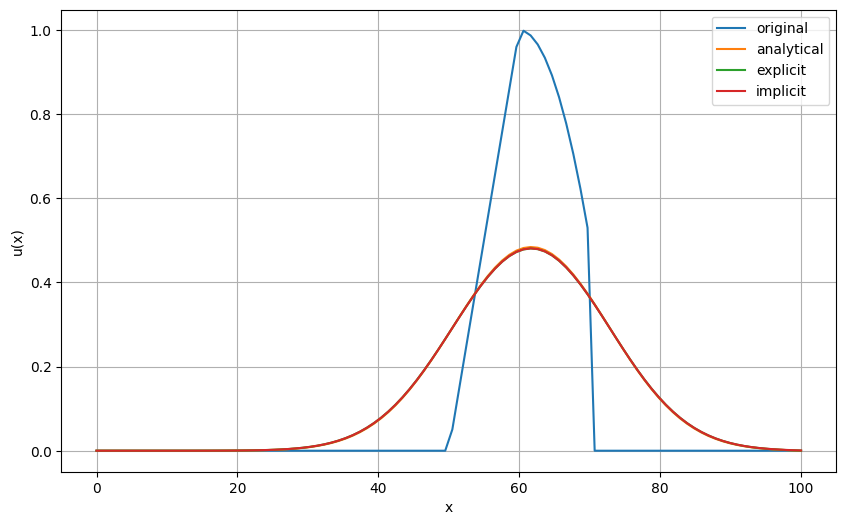

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve


hx = 1
ht = 0.05
N = 100
T = 50
a = 1.0
L = 100.0



x_steps = int(N)
time_steps = int(T / ht)


x = np.linspace(0, L, x_steps)
t = np.linspace(0, T, time_steps)
domain_length = 100.0  

def f(x):
    if 50 <= x <= 60:
        return (x - 50) / 10
    elif 60 < x <= 70:
        return -((x - 60) ** 2) / 200 + 1
    return 0


u_initial = np.array([f(xi) for xi in x])
sigma = a * ht / (hx ** 2)


u_explicit = np.zeros((time_steps, x_steps))
u_explicit[0, :] = u_initial.copy()

for n in range(0, time_steps - 1):
    for i in range(1, x_steps - 1):
        u_explicit[n + 1, i] = u_explicit[n, i] + sigma * (u_explicit[n, i - 1] - 2 * u_explicit[n, i] + u_explicit[n, i + 1])


def run_through(a, b, c, d):
    n = len(d)
    alf = np.zeros(n - 1)
    bet = np.zeros(n)
    x = np.zeros(n)

    alf[0] = c[0] / b[0]
    bet[0] = d[0] / b[0]
    for i in range(1, n - 1):
        denom = b[i] - a[i] * alf[i - 1]
        alf[i] = c[i] / denom
        bet[i] = (d[i] - a[i] * bet[i - 1]) / denom
    bet[-1] = (d[-1] - a[-1] * bet[-2]) / (b[-1] - a[-1] * alf[-2])

    x[-1] = bet[-1]
    for i in range(n - 2, -1, -1):
        x[i] = bet[i] - alf[i] * x[i + 1] 

    return x

off_diagonals = np.full(x_steps - 1, -sigma)
diagonal = np.full(x_steps, 1 + 2 * sigma)
u_implicit = np.zeros((time_steps, x_steps))
u_implicit[0, :] = u_initial.copy()

for n in range(0, time_steps - 1):
    d = u_implicit[n, :].copy()
    u_implicit[n + 1, :] = run_through(off_diagonals, diagonal, off_diagonals, d)

def analytical_solution(x, t, scale_factor=1):
    sum_terms = np.zeros_like(x)
    num_terms = 100
    for n in range(1, num_terms):
        B_n = (2 / L) * np.trapezoid(u_initial * np.sin(n * np.pi * x / L), x)
        sum_terms += scale_factor * B_n * np.exp(- (n * np.pi / L) ** 2 * a * t) * np.sin(n * np.pi * x / L)
    return sum_terms

space = np.linspace(0, domain_length, x_steps)
initial_temperature = np.array([f(xi) for xi in space])


def fourier_coefficients(x, initial_temp, num_terms=100):
    B_n_values = []
    for n in range(1, num_terms):
        B_n = (2 / domain_length) * np.trapezoid(initial_temp * np.sin(n * np.pi * x / domain_length), x)
        B_n_values.append(B_n)
    return B_n_values


def inverse_fourier_transform(B_n_values, x):
    sum_terms = np.zeros_like(x)
    for n, B_n in enumerate(B_n_values, start=1):
        sum_terms += B_n * np.sin(n * np.pi * x / domain_length)
    return sum_terms

u_analytical_last = analytical_solution(x, T)

B_n_values = fourier_coefficients(space, initial_temperature)
inverse_solution = inverse_fourier_transform(B_n_values, space)

plt.figure(figsize=(10, 6))
plt.plot(x, u_initial, label="original")      
plt.plot(x, u_analytical_last, label="analytical")  
plt.plot(x, u_explicit[-1, :], label="explicit") 
plt.plot(x, u_implicit[-1, :], label="implicit")   
plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend(loc="best")
plt.grid()
plt.show()